In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
data_time = pd.read_csv("E:/2024/July2024/Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")


C:\Users\OKOK D2\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx].unsqueeze(0), 'label': self.labels[idx]}
        return sample

# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data_scaled, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data_scaled, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Define simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters for the RNN model
input_size = train_data_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = len(data_time['fault'].unique())

# Initialize model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

Epoch 1/50, Loss: 2.2361623511022453
Epoch 2/50, Loss: 1.7335246412121519
Epoch 3/50, Loss: 1.2095725463361156
Epoch 4/50, Loss: 0.9191748901289336
Epoch 5/50, Loss: 0.7054046282962877
Epoch 6/50, Loss: 0.5504699586605539
Epoch 7/50, Loss: 0.46503022951739176
Epoch 8/50, Loss: 0.3966313120053739
Epoch 9/50, Loss: 0.3572295815969
Epoch 10/50, Loss: 0.3256185206831718
Epoch 11/50, Loss: 0.29906248073188624
Epoch 12/50, Loss: 0.2763214530993481
Epoch 13/50, Loss: 0.2572350313468855
Epoch 14/50, Loss: 0.24174995796412838
Epoch 15/50, Loss: 0.2270903751558187
Epoch 16/50, Loss: 0.2117833922408065
Epoch 17/50, Loss: 0.2035189242083199
Epoch 18/50, Loss: 0.19628450593778066
Epoch 19/50, Loss: 0.18691562313814553
Epoch 20/50, Loss: 0.18106955122582766
Epoch 21/50, Loss: 0.1745036973484925
Epoch 22/50, Loss: 0.1708663780318231
Epoch 23/50, Loss: 0.16274004923749943
Epoch 24/50, Loss: 0.16405711072135945
Epoch 25/50, Loss: 0.1579669489696318
Epoch 26/50, Loss: 0.1519974638156745
Epoch 27/50, Los

Epoch 1/50, Loss: 2.235044535325498
Epoch 2/50, Loss: 1.8030263866697038
Epoch 3/50, Loss: 1.3755345636484575
Epoch 4/50, Loss: 1.029819157658791
Epoch 5/50, Loss: 0.7833292429544487
Epoch 6/50, Loss: 0.5907092270802479
Epoch 7/50, Loss: 0.4605437930749387
Epoch 8/50, Loss: 0.39652784472825575
Epoch 9/50, Loss: 0.35199793321745737
Epoch 10/50, Loss: 0.3184515362491413
Epoch 11/50, Loss: 0.30063098273715194
Epoch 12/50, Loss: 0.27345809142808525
Epoch 13/50, Loss: 0.25625655724077806
Epoch 14/50, Loss: 0.2376911410567712
Epoch 15/50, Loss: 0.21953235718668723
Epoch 16/50, Loss: 0.20667520553177718
Epoch 17/50, Loss: 0.19893923363819413
Epoch 18/50, Loss: 0.18676118963226981
Epoch 19/50, Loss: 0.18070086639146415
Epoch 20/50, Loss: 0.1726189021553312
Epoch 21/50, Loss: 0.16775306359845765
Epoch 22/50, Loss: 0.16698614310245125
Epoch 23/50, Loss: 0.1609815903464142
Epoch 24/50, Loss: 0.1575169180881004
Epoch 25/50, Loss: 0.1504377582091458
Epoch 26/50, Loss: 0.14626590922778968
Epoch 27/5

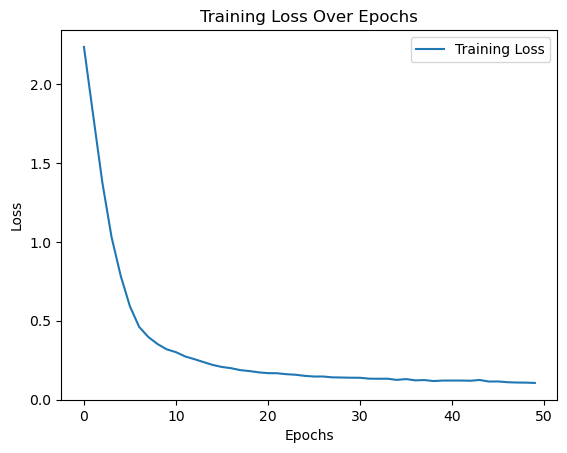

Accuracy on test set: 0.96

Classification Report:
              precision    recall  f1-score   support

  Ball_007_1       0.94      0.99      0.96        75
  Ball_014_1       0.94      0.84      0.89        75
  Ball_021_1       0.92      0.91      0.91        75
    IR_007_1       0.99      1.00      0.99        75
    IR_014_1       1.00      1.00      1.00        75
    IR_021_1       1.00      1.00      1.00        75
    Normal_1       0.97      1.00      0.99        75
  OR_007_6_1       1.00      1.00      1.00        75
  OR_014_6_1       0.86      0.88      0.87        75
  OR_021_6_1       0.99      0.99      0.99        75

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load the dataset
data_time = pd.read_csv("C:/Users/OKOK PRO/Downloads/CODE_Fault_Classification/Dataset/feature_time_48k_2048_load_1.csv")

# Scale each column to have zero mean and standard deviation equal to 1
scaler = StandardScaler()
train_data, test_data = train_test_split(data_time, test_size=750, stratify=data_time['fault'], random_state=1234)

# Scale the training data
train_data_scaled = scaler.fit_transform(train_data.iloc[:, :-1])
train_data_scaled = torch.tensor(train_data_scaled, dtype=torch.float32)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_data['fault'])
train_labels = torch.tensor(train_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Scale the testing data
test_data_scaled = (test_data.iloc[:, :-1].values - scaler.mean_) / np.sqrt(scaler.var_)
test_data_scaled = torch.tensor(test_data_scaled, dtype=torch.float32)

test_labels_encoded = label_encoder.transform(test_data['fault'])
test_labels = torch.tensor(test_labels_encoded, dtype=torch.int64)  # Use dtype=torch.int64 for labels

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx].unsqueeze(0), 'label': self.labels[idx]}
        return sample

# Create data loaders
batch_size = 32

train_dataset = CustomDataset(train_data_scaled, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataset(test_data_scaled, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parameters for the RNN model
input_size = train_data_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = len(data_time['fault'].unique())

# Initialize model, loss function, and optimizer
model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        inputs, labels = batch['data'], batch['label']
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

# Plot the loss over epochs
plt.plot(range(num_epochs), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on test data
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch['data'], batch['label']
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f"Accuracy on test set: {accuracy}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


In [2]:
torch.save(model.state_dict(), 'fault_type_rnn_model.pth')

In [4]:
import streamlit as st
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Load the model
model = SimpleRNN(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('fault_type_rnn_model.pth'))
model.eval()

# Define the input data processing functions
scaler = StandardScaler()
label_encoder = LabelEncoder()

def preprocess_input(data):
    data_scaled = scaler.transform(data)
    data_tensor = torch.tensor(data_scaled, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return data_tensor

# Streamlit UI
st.title("Fault Type Prediction")

# Input fields for features (replace with your actual feature names and input types)
feature_1 = st.number_input("Feature 1")
feature_2 = st.number_input("Feature 2")
feature_3 = st.number_input("Feature 3")
feature_4 = st.number_input("Feature 4")
feature_5 = st.number_input("Feature 5")
feature_6 = st.number_input("Feature 6")
feature_7 = st.number_input("Feature 7")
feature_8 = st.number_input("Feature 8")
feature_9 = st.number_input("Feature 9")
# Add more features as required

# Prepare the input for the model
input_data = np.array([[feature_1, feature_2]])  # Replace with all input features
input_tensor = preprocess_input(input_data)

# Predict
if st.button("Predict Fault Type"):
    with torch.no_grad():
        prediction = model(input_tensor)
        predicted_class = torch.argmax(prediction, 1).item()
        predicted_fault_type = label_encoder.inverse_transform([predicted_class])[0]
        st.write(f"Predicted Fault Type: {predicted_fault_type}")



SyntaxError: invalid syntax (954607725.py, line 63)

In [5]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)